## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist is created!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fmnist/FashionMNIST/raw



In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 128]         100,480
              ReLU-3                  [-1, 128]               0
            Linear-4                  [-1, 128]          16,512
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_function = nn.CrossEntropyLoss()

def train_model(model, train_loader, val_loader, loss_fn, opt, n_epochs: int, device=device):
    loss_training, loss_val, acc_val = [], [], []
    for epoch in range(n_epochs):
        ep_loss_training, ep_val_loss, ep_acc_val = [], [], []
        ep_val_loss = []
        ep_acc_val = []
        model.train(True)
        for X_batch, y_batch in train_loader:
            opt.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            out = model(X_batch)   
            loss = loss_fn(out, y_batch)
            loss.backward()
            opt.step()
            ep_loss_training.append(loss.item())
        model.train(False) 
        with torch.no_grad():
            for X_batch, y_batch in val_loader:           
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                out = model(X_batch)
                loss = loss_fn(out, y_batch)
                ep_val_loss.append(loss.item())
                y_pred = out.max(dim=1)[1]
                ep_acc_val.append(np.sum(y_batch.cpu().numpy() == y_pred.cpu().numpy().astype(float))/ len(y_batch.cpu()))
        print("epoch ", end='')
        print(epoch)

        loss_training.append(np.mean(ep_loss_training))
        loss_val.append(np.mean(ep_val_loss))
        acc_val.append(np.mean(ep_acc_val))

        print("training loss:     ", end='') 
        print(loss_training[-1])
        print("validation accuracy:     ", end='')
        print(acc_val[-1])
    return loss_training, loss_val, acc_val

n_epochs = 15
import time
loss_training, loss_val, acc_val = train_model(model, train_loader, test_loader, loss_function, opt, n_epochs)

epoch 0
training loss:     0.5850565910720622
validation accuracy:     0.83740234375
epoch 1
training loss:     0.39542274412188705
validation accuracy:     0.85537109375
epoch 2
training loss:     0.35744284099734414
validation accuracy:     0.8607421875
epoch 3
training loss:     0.3330154136808188
validation accuracy:     0.861328125
epoch 4
training loss:     0.313436503873578
validation accuracy:     0.87412109375
epoch 5
training loss:     0.29894161996429663
validation accuracy:     0.8759765625
epoch 6
training loss:     0.2857349487001708
validation accuracy:     0.8771484375
epoch 7
training loss:     0.27717475621685034
validation accuracy:     0.876171875
epoch 8
training loss:     0.2645128323579394
validation accuracy:     0.8857421875
epoch 9
training loss:     0.2533519680121306
validation accuracy:     0.85693359375
epoch 10
training loss:     0.249912358439172
validation accuracy:     0.88369140625
epoch 11
training loss:     0.23824889039688274
validation accuracy:  

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [10]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 500),
            nn.LeakyReLU(),
            nn.Linear(500,300),
            nn.LeakyReLU(),
            nn.Linear(300, 100),
            nn.LeakyReLU(),
            nn.Linear(100,10),
            nn.LeakyReLU(),
            nn.Linear(10,num_classes)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [11]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 500]         392,500
         LeakyReLU-3                  [-1, 500]               0
            Linear-4                  [-1, 300]         150,300
         LeakyReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 100]          30,100
         LeakyReLU-7                  [-1, 100]               0
            Linear-8                   [-1, 10]           1,010
         LeakyReLU-9                   [-1, 10]               0
           Linear-10                   [-1, 10]             110
Total params: 574,020
Trainable params: 574,020
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 2.19
Estimated T

In [12]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 25
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

epoch 0
training loss:     0.6521992403179852
validation accuracy:     0.834765625
epoch 1
training loss:     0.39295647348930585
validation accuracy:     0.86318359375
epoch 2
training loss:     0.3427134862840811
validation accuracy:     0.86650390625
epoch 3
training loss:     0.3185245317818005
validation accuracy:     0.86923828125
epoch 4
training loss:     0.29590707391436927
validation accuracy:     0.8701171875
epoch 5
training loss:     0.2785134473716272
validation accuracy:     0.8791015625
epoch 6
training loss:     0.2646851835569847
validation accuracy:     0.8791015625
epoch 7
training loss:     0.2537476627398401
validation accuracy:     0.87900390625
epoch 8
training loss:     0.2439350600499334
validation accuracy:     0.88330078125
epoch 9
training loss:     0.23625599961481622
validation accuracy:     0.88193359375
epoch 10
training loss:     0.22300830386531378
validation accuracy:     0.8822265625
epoch 11
training loss:     0.21637902059344086
validation accurac

0.8990234375


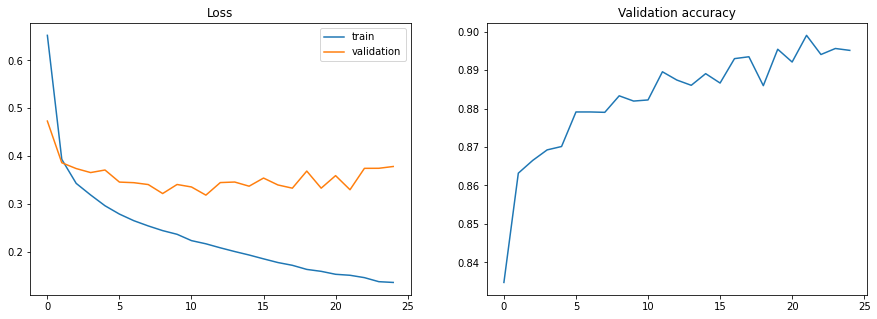

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title('Loss')
axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='validation')
axes[0].legend()
axes[1].set_title('Validation accuracy')
axes[1].plot(val_accuracy)
print(np.max(val_accuracy))

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [14]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 600),
            nn.BatchNorm1d(600),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(600,500),
            nn.BatchNorm1d(500),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(500, 400),
            nn.BatchNorm1d(400),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(400,300),
            nn.BatchNorm1d(300),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(300,200),
            nn.BatchNorm1d(200),
            nn.LeakyReLU(),
            nn.Dropout(), 
            nn.Linear(200,100),
            nn.BatchNorm1d(100),
            nn.LeakyReLU(),
            nn.Dropout(),
            nn.Linear(100,10)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [15]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 600]         471,000
       BatchNorm1d-3                  [-1, 600]           1,200
         LeakyReLU-4                  [-1, 600]               0
           Dropout-5                  [-1, 600]               0
            Linear-6                  [-1, 500]         300,500
       BatchNorm1d-7                  [-1, 500]           1,000
         LeakyReLU-8                  [-1, 500]               0
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 400]         200,400
      BatchNorm1d-11                  [-1, 400]             800
        LeakyReLU-12                  [-1, 400]               0
          Dropout-13                  [-1, 400]               0
           Linear-14                  [

In [18]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
n_epochs = 20
train_loss, val_loss, val_accuracy = train_model(model, train_loader, test_loader, loss_func, opt, n_epochs)

epoch 0
training loss:     0.9268453682917775
validation accuracy:     0.7994140625
epoch 1
training loss:     0.5859424916030501
validation accuracy:     0.83701171875
epoch 2
training loss:     0.5175880267421828
validation accuracy:     0.85625
epoch 3
training loss:     0.482937773661827
validation accuracy:     0.86435546875
epoch 4
training loss:     0.4553455187440681
validation accuracy:     0.855078125
epoch 5
training loss:     0.4402374505742527
validation accuracy:     0.87275390625
epoch 6
training loss:     0.42761196351763026
validation accuracy:     0.87177734375
epoch 7
training loss:     0.41153170816552664
validation accuracy:     0.8712890625
epoch 8
training loss:     0.3988247201132622
validation accuracy:     0.87744140625
epoch 9
training loss:     0.3923031196856041
validation accuracy:     0.8775390625
epoch 10
training loss:     0.38183371875204764
validation accuracy:     0.8779296875
epoch 11
training loss:     0.3763178312765764
validation accuracy:     0.

0.8990234375


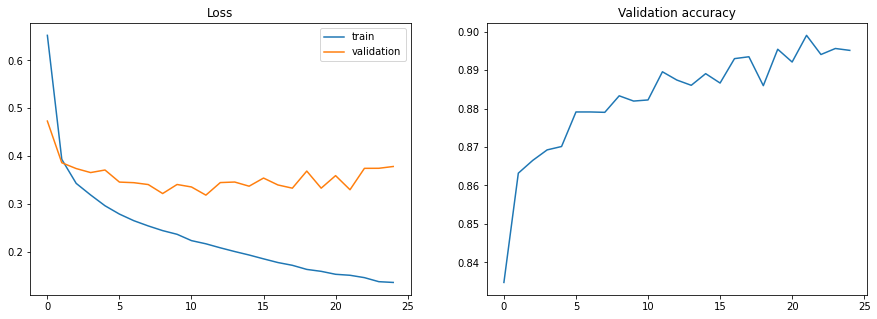

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].set_title('Loss')
axes[0].plot(train_loss, label='train')
axes[0].plot(val_loss, label='validation')
axes[0].legend()
axes[1].set_title('Validation accuracy')
axes[1].plot(val_accuracy)
print(np.max(val_accuracy))

### Conclusions:
_Write down small report with your conclusions and your ideas._

The training accuracy increases with increase in number of epochs.
The effectiveness of tools like batchnorm and dropout in reducing overfitting also serves as evidence of how well these techniques work in creating better models.
